In [ ]:
!pip install datasets
!pip install transformers
!pip install accelerate
from datasets import load_dataset

dataset = load_dataset("jonathanli/human-essays-reddit")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:

from transformers import AutoModelForCausalLM,AutoTokenizer, pipeline
import torch



def generate_text(length,prompt,model,tokenizer):

  # Tokenize the prompt
  inputs = tokenizer(prompt, return_tensors="pt")

  # Generate text
  output = model.generate(
      inputs.input_ids,
      max_length= min(length,512),  # Adjust the length as needed
      temperature=0.7,  # Adjust the temperature for more or less randomness
      top_k=50,  # Adjust for diversity
      top_p=0.95,  # Adjust for diversity
      do_sample=True,
      num_return_sequences=1  # Number of sequences to generate
  )

  # Decode the generated output
  try:
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
  except:
    generated_text = tokenizer.decode(output, skip_special_tokens=True)
  return generated_text,inputs.input_ids.shape[0]

In [ ]:
def generate_text_loop(prompter,length,model,tokenizer):

  #Set Model Output to 400 words or less
  if length > 400:
    word_length = 400
  else:
    word_length = length
  question = f"You are a redditor writing for a creative writing subreddit. \
   I will give you the first few sentences and you will fill out the rest try to make it around {word_length} words. The story starts like:{prompter}"

  #Remove prompt from return output
  question_removal = f"You are a redditor writing for a creative writing subreddit. \
   I will give you the first few sentences and you will fill out the rest try to make it around {word_length} words. The story starts like:"
  ans = generate_text(word_length,question,model,tokenizer)


  #Clean Answer
  try:
    cleaned_ans = ans[ans.index(question_removal) + len(question_removal):]
  except:
    cleaned_ans = ans


  return cleaned_ans

In [ ]:
def get_perplexity(text,tokenizer,model):
  with torch.no_grad():
      tokenized = tokenizer(text, return_tensors="pt")
      labels = tokenized.input_ids
      outpt = model(**tokenized,labels = labels)
      num_of_tokens = labels.numel()
      probabilities = torch.gather(torch.softmax(outpt.logits,dim = -1).squeeze(0),1,torch.argmax(torch.softmax(outpt.logits,dim = -1),dim = -1).reshape(num_of_tokens,1))
      return -torch.sum(torch.log(probabilities),dim = 0).item()/num_of_tokens

#get_perplexity(cleaned_ans,tokenizer,model)

In [ ]:
def get_cross_perplexity(text,tokenizer1,model1,tokenizer2,model2):
  with torch.no_grad():

      ##M(1) Observer Model
      tokenized_1 = tokenizer1(text, return_tensors="pt")
      labels_1 = tokenized_1.input_ids
      outpt_1 = model1(**tokenized_1,labels = labels_1)
      num_of_tokens_1 = labels_1.numel() ###Paper uses
      probabilities_1 = torch.gather(torch.softmax(outpt_1.logits,dim = -1).squeeze(0),1,torch.argmax(torch.softmax(outpt_1.logits,dim = -1),dim = -1).reshape(num_of_tokens_1,1))

      ##Log M(2) Performer Model
      tokenized_2 = T_2(text, return_tensors="pt")
      labels_2 = tokenized_2.input_ids
      outpt_2 = M_2(**tokenized_1,labels = labels_1)
      num_of_tokens_2 = labels_2.numel()
      probabilities_2 = torch.log(torch.gather(torch.softmax(outpt_2.logits,dim = -1).squeeze(0),1,torch.argmax(torch.softmax(outpt_2.logits,dim = -1),dim = -1).reshape(num_of_tokens_2,1)))

      #Model uses Observer Model as the token count
      return torch.dot(probabilities_1.squeeze(1),probabilities_2.squeeze(1))/num_of_tokens_1




In [ ]:
import pandas as pd


qualitative_samples = pd.DataFrame(columns=['human/ai','text','Binocular score','length'])
iterations = 100
modeltype_1 = "tiiuae/falcon-7b-instruct"
modeltype_2 = "tiiuae/falcon-7b"

M_1 = AutoModelForCausalLM.from_pretrained(modeltype_1)
T_1 = AutoTokenizer.from_pretrained(modeltype_1)



M_2 = AutoModelForCausalLM.from_pretrained(modeltype_2)
T_2 = AutoTokenizer.from_pretrained(modeltype_2)





Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/16.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.48G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [ ]:
for i in range(iterations):

  #get prompt and answer word length for text generation
  prompt = " ".join(dataset['train']['top_comment'][i].split()[:30])
  length = len(dataset['train']['top_comment'][i].split())

  #Generate Cleaned Answer with no prompt from model
  AI_text,sequence_lengths = generate_text_loop(prompt,length,M_1,T_1)

  #original text
  original_text = dataset['train']['top_comment'][i]

  #Binocular Scores
  human_score = get_perplexity(original_text,T_1,M_1)/get_cross_perplexity(original_text,T_1,M_1,T_2,M_2)
  ai_score = get_perplexity(AI_text,T_1,M_1)/get_cross_perplexity(AI_text,T_1,M_1,T_2,M_2)


  qualitative_samples.loc[len(qualitative_samples)] = ['human',original_text,human_score,sequence_lengths]
  qualitative_samples.loc[len(qualitative_samples)] = ['ai',AI_text,ai_score,sequence_lengths]
  print(i,'is done!')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


0 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


1 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


2 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


3 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


4 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


5 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


6 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


7 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


8 is done!
9 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


10 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


11 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


12 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


13 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


14 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


15 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


16 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


17 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


18 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


19 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


20 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


21 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


22 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


23 is done!
24 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


25 is done!
26 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


27 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


28 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


29 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


30 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


31 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


32 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


33 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


34 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


35 is done!
36 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


37 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


38 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


39 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


40 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


41 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


42 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


43 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


44 is done!
45 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


46 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


47 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


48 is done!
49 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


50 is done!
51 is done!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:11 for open-end generation.


KeyboardInterrupt: 

In [ ]:
import seaborn as sns
sns.jointplot(x="length'", y="Binocular score", data=qualitative_samples,hue = 'human/ai')

ValueError: Could not interpret value `length'` for `x`. An entry with this name does not appear in `data`.

In [ ]:
qualitative_samples['Binocular score'] = qualitative_samples['Binocular score'].apply(lambda x: x.item())

In [ ]:
sequence_lengths

1

<Axes: xlabel='human/ai', ylabel='Binocular score'>

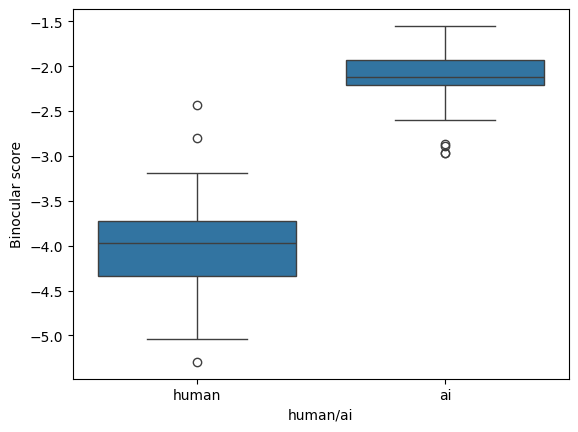

In [ ]:
sns.boxplot(data=qualitative_samples , x="human/ai", y="Binocular score")